In [1]:
# conda install -c juconda install -c conda-forge ipywidgets
# conda install -c conda-forge nodejs
# jupyter labextension install @jupyterlab/plotly-extension
# jupyter labextension install @jupyter-widgets/jupyterlab-manager
# jupyter labextension install plotlywidget
# jupyter labextension install jupyterlab-chart-editor

In [2]:
from importlib import reload
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import re

from binance.client import Client
from binance import enums

In [3]:
# Your API key and secret
API_KEY = "KFtd2cWoESXyJqpDS8x38XZIK50FWgAsUwYAg4nQ4gJSEPEO0lzYj8LROQvpp7fO"
API_SECRET = "XSEHZynFQx4dN3FtTgOIwpW3bP50dFjG6UGsQwdLnTsO53cHxevc1bRj4Ztt4VmX"

In [4]:
client = Client(API_KEY, API_SECRET)

In [5]:
# List of pairs you want to track
pairs = [
    ('BTC', 'USDT'),
    ('ETH', 'USDT'),
    ('XRP', 'USDT'),
    ('LTC', 'USDT'),
    ('BNB', 'USDT')
]
# https://python-binance.readthedocs.io/en/latest/genindex.html
# Kline/candlestick interval
# Fetch double of that to display in order to calculate windows correctly
interval = enums.KLINE_INTERVAL_1DAY
limit = 90

In [6]:
from cryptoz.binance import BinanceHelper
from cryptoz import utils, stats, plot

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [7]:
binance = BinanceHelper(client)

## Data

In [8]:
data_dict = binance.get_multiple_pair_ohlcv(pairs, interval, limit=limit)

In [9]:
data_dict.keys()

dict_keys([('BTC', 'USDT'), ('ETH', 'USDT'), ('XRP', 'USDT'), ('LTC', 'USDT'), ('BNB', 'USDT')])

## Basic analysis

### Price development

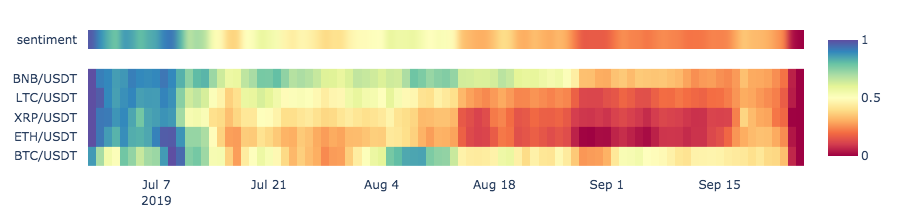

In [10]:
# Select a column from each OHLCV dataframe and stack into a new one
df = utils.select_from_dict(data_dict, 'M')

# We want to somehow compare prices of all assets
# Thus let's normalize the prices based on their performance
# To have a better overview, we normalize here with respect to both past and future
# In more sensitive settings, use expanding_normalize to use the past data only.
df = utils.normalize(df, 'minmax')

# Plot price evolution (i.e. price development heatmap)
# 1: the highest price (for a pair and window)
# 0: the lowest price
plot.time_heatmap(df, cmap='Spectral')

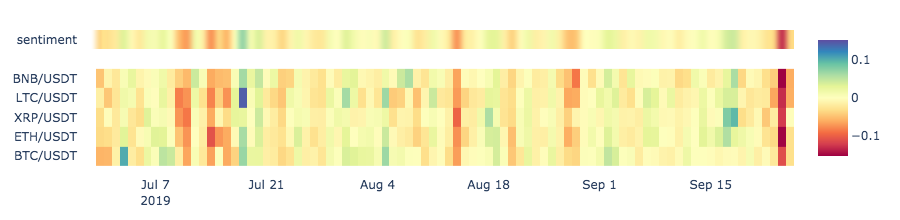

In [11]:
# Percentage change between the current and a prior price (returns)
df = utils.select_from_dict(data_dict, 'M')
df = df.pct_change()

plot.time_heatmap(df)

### Anomaly detection

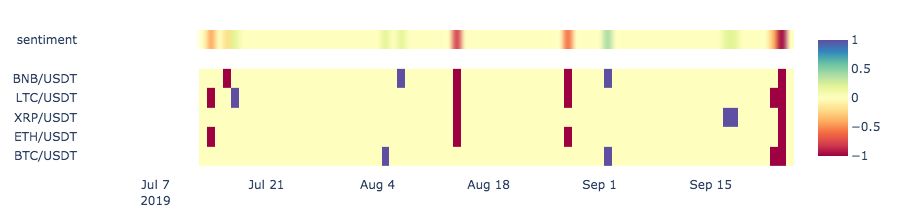

In [12]:
# Use rolling standardization to get price anomalies
df = utils.select_from_dict(data_dict, 'C') # Close price
df = df.pct_change() # Daily price change
df = utils.rolling_normalize(df, 'std', window=14) # Z
zth = 2 # Z threshold
df[(df < zth) & (df > -zth)] = 0
df[df >= zth] = 1
df[df <= -zth] = -1

plot.time_heatmap(df)

### Volatility

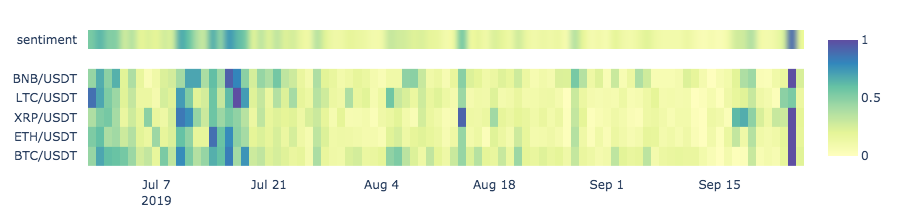

In [13]:
# High - low normalized
df = utils.select_from_dict(data_dict, 'H')-utils.select_from_dict(data_dict, 'L')
df = utils.normalize(df, 'minmax')

plot.time_heatmap(df)

In [14]:
# Coefficient of variation (normalized volatility)
df = utils.select_from_dict(data_dict, 'M')
df = df.std() / df.mean()
df.sort_values()

BTC  USDT    0.072585
XRP  USDT    0.150286
BNB  USDT    0.163615
ETH  USDT    0.182673
LTC  USDT    0.209834
dtype: float64

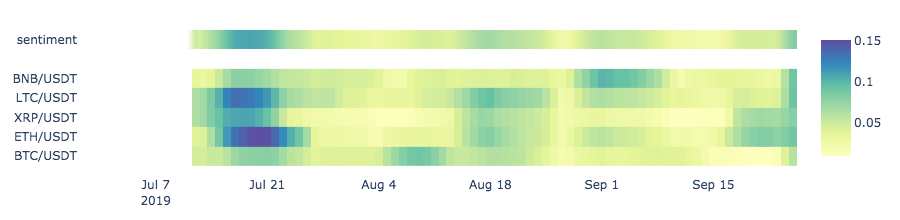

In [15]:
# Show development of the normalized volatility (smoothed)
df = utils.select_from_dict(data_dict, 'M')
df = df.rolling(14).std() / df.rolling(14).mean()

# No negative values, thus take viridis
plot.time_heatmap(df)

### Maximum drawdown

In [16]:
# Get maximum drawdown now, use the highest price at each step
df = utils.select_from_dict(data_dict, 'H')
stats.mdd(df).iloc[-1]

BTC  USDT    0.335974
ETH  USDT    0.461569
XRP  USDT    0.425419
LTC  USDT    0.580544
BNB  USDT    0.539436
Name: 2019-09-25 00:00:00, dtype: float64

In [17]:
stats.dd_info(df)

{('BTC',
  'USDT'):        start     valley        end dd_duration rec_duration  dd_rate (%)  \
 0 2019-06-29 2019-07-02 2019-07-09      3 days       7 days    12.078810   
 1 2019-07-10 2019-09-25        NaT     77 days          NaT    33.597422   
 
    rec_rate (%)  
 0     16.967021  
 1           NaN  ,
 ('ETH',
  'USDT'):        start     valley   end dd_duration rec_duration  dd_rate (%)  \
 0 2019-06-29 2019-08-30  None     62 days         None    47.413315   
 
   rec_rate (%)  
 0         None  ,
 ('XRP',
  'USDT'):        start     valley   end dd_duration rec_duration  dd_rate (%)  \
 0 2019-06-29 2019-09-25  None     88 days         None     42.54186   
 
   rec_rate (%)  
 0         None  ,
 ('LTC',
  'USDT'):        start     valley   end dd_duration rec_duration  dd_rate (%)  \
 0 2019-06-30 2019-09-25  None     87 days         None    58.054424   
 
   rec_rate (%)  
 0         None  ,
 ('BNB',
  'USDT'):        start     valley   end dd_duration rec_duration  dd_rate 

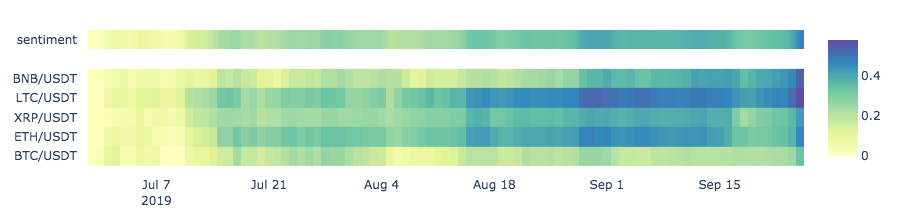

In [18]:
# Visualize the drawdown development across the pairs and time scale
df = utils.select_from_dict(data_dict, 'H')
df = stats.mdd(df)

plot.time_heatmap(df)

### Correlation between pairs

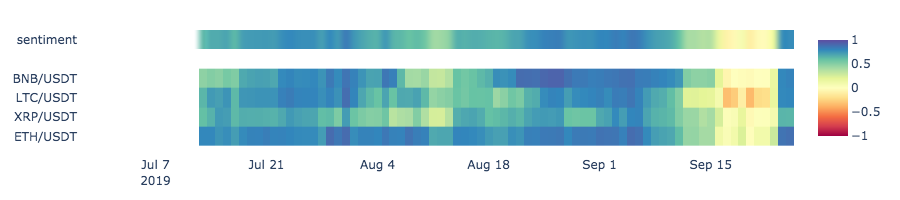

In [19]:
df = utils.select_from_dict(data_dict, 'M')
df = df.pct_change()
# Rolling correlation of each pair with BTC/USDT for the last 14 steps 
df = stats.rolling_corr(df, ('BTC', 'USDT'), window=14)
df = df.drop(('BTC', 'USDT'), axis=1) # corr(BTCUSDT, BTCUSDT) = 1

# If the value range is known, pass it with vmin and vmax
plot.time_heatmap(df, vmin=-1, vmax=1)

## Technical indicators

### RSI

In [20]:
def RSI(df, window):
    """Calculate Relative Strength Index (RSI)"""
    delta = df.diff().dropna()
    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # Calculate the EWMA
    roll_up = up.ewm(window, min_periods=window).mean()
    roll_down = down.abs().ewm(window, min_periods=window).mean()

    # Calculate the RSI based on EWMA
    return 100.0 - (100.0 / (1.0 + roll_up / roll_down))

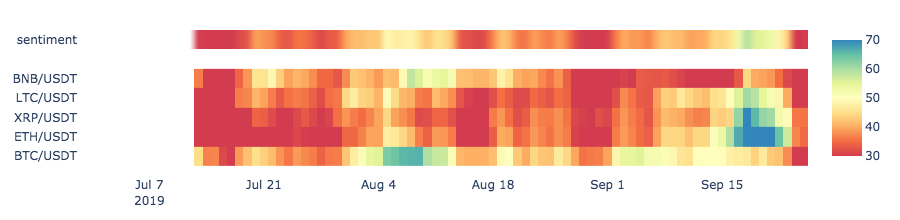

In [21]:
# Calculate RSI and display as a heatmap with 30 being oversold and 70 overbought
df = utils.select_from_dict(data_dict, 'M')
df = RSI(df, 14)

norm = plot.MidpointNormalize(50, vmin=30, vmax=70)
plot.time_heatmap(df, norm=norm, vmin=30, vmax=70, cmap_range=(0.1, 0.9))

### CCI

In [22]:
def CCI(df, window):
    """Calculate Commodity Channel Index (CCI)"""
    # (Typical Price - 20-period SMA of TP) / (.015 x Mean Deviation)
    tp_sma = df.rolling(window).mean()
    md = df.rolling(window).apply(lambda a: np.fabs(a - a.mean()).mean(), raw=False)
    # 70-80% of all calculations will fall between the established +100 or -100 range
    return (df - tp_sma) / (.015 * md)

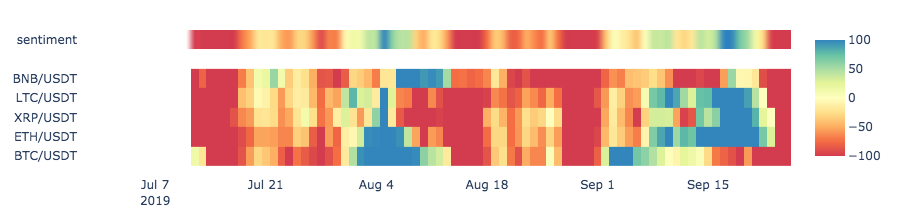

In [23]:
df = utils.select_from_dict(data_dict, 'M')
df = CCI(df, 14)

norm = plot.MidpointNormalize(0, vmin=-100, vmax=100)
plot.time_heatmap(df, norm=norm, vmin=-100, vmax=100, cmap_range=(0.1, 0.9))

### SMA crossover

In [24]:
def SMA_events(df, sma_fast, sma_slow):
    """Generate SMA crossover events."""
    fast = df.rolling(sma_fast, min_periods=sma_fast).mean()
    slow = df.rolling(sma_slow, min_periods=sma_slow).mean()
    df = fast - slow
    isnull = df.isnull()
    df[df > 0] = 1
    df[df < 0] = -1
    df = df.fillna(0)
    df = df.diff().dropna()
    pos_mask = df == 2
    neg_mask = df == -2
    df[pos_mask] = 1
    df[neg_mask] = -1
    df[~neg_mask & ~pos_mask] = 0
    df[isnull] = np.nan
    return df

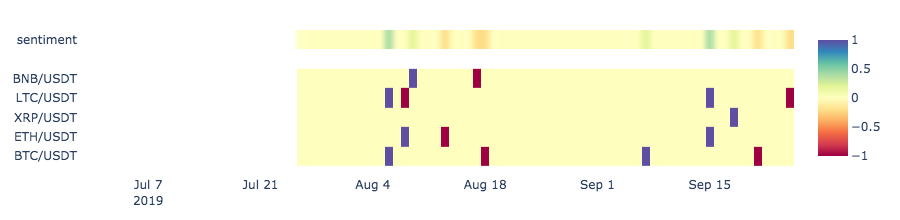

In [25]:
# Generate events where 7 and 21-day moving averages are crossing
df = utils.select_from_dict(data_dict, 'M')
df = SMA_events(df, 7, 28)

plot.time_heatmap(df)

### Bollinger Bands

In [26]:
def BB(df, window, k):
    """Return the lower and the upper Bollinger Bands"""
    sma = df.rolling(window=window, min_periods=window).mean()
    std = df.rolling(window=window, min_periods=window).std()
    BOLU = sma + std * k
    BOLD = sma - std * k
    return BOLD, BOLU

def BB_width(BOLD, BOLU):
    """Return the width of the corridor between the bands"""
    return BOLU - BOLD

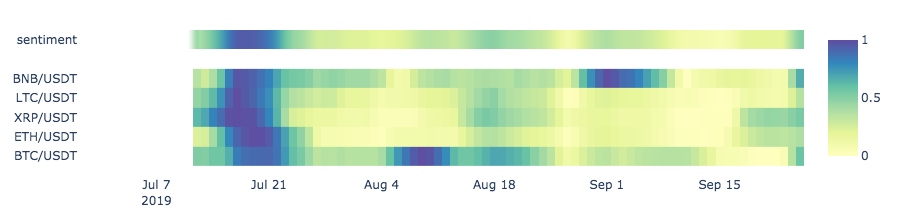

In [27]:
# How wide are Bollinger Bands?
df = utils.select_from_dict(data_dict, 'M')
df = BB_width(*BB(df, 14, 2))
df = utils.normalize(df, 'minmax')

plot.time_heatmap(df)

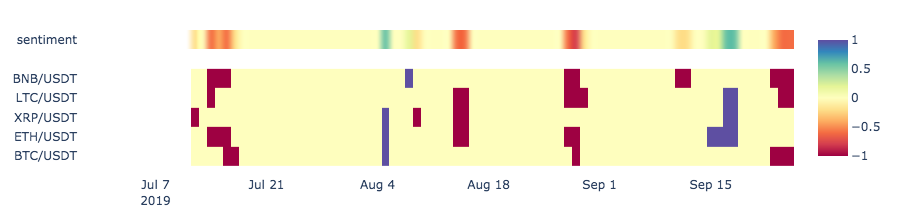

In [28]:
# Where is the price, inside or outside of BBs? A good indicator for sudden price jumps.
# > 1: exceeds the upper band
# < -1: exceeds the lower band
df = utils.select_from_dict(data_dict, 'M')
# To track the price relative to BBs, we need to rescale it to 0..1 where 0 is lower and 1 upper BB
# BB range is a time-series itself (a variable source range), hence the name "dynamic rescaling"
df = utils.dynamic_rescale(df, BB(df, 14, 2), [-1, 1])
# Produce events where the price jumps inside or outside
df[df >= 1] = 1
df[df <= -1] = -1
df[(-1 < df) & (df < 1)] = 0

plot.time_heatmap(df)